# Offset Ground-truthing

## In geo environment

In [46]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime

In [70]:
path = 'peg_data/Rangitikei Landslide_peg displacement_sample.xlsx'
names = ['P22','P21','P14','P11','P5']
df = pd.DataFrame()

for n in names:
    temp = pd.read_excel(path, sheet_name=n).sort_values('Survey date')
    temp['Cumulative E disp'] = temp['E disp'].cumsum()
    temp['Cumulative N disp'] = temp['N disp'].cumsum()
    df = df.append(temp)

In [71]:
pegs = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df['Easting'], y=df['Northing'], z=df['Elevation (NZVD2016)'], crs='EPSG:2193'))

In [72]:
pegs = pegs.to_crs(epsg=32760)

pegs['Easting'] = pegs.geometry.x
pegs['Northing'] = pegs.geometry.y
pegs['Elevation'] = pegs.geometry.z

In [73]:
pegs.to_csv('peg_data/pegs_32760.csv')
print(pegs.columns)

Index(['Survey date', 'Name', 'Survey number', 'Easting', 'Northing',
       'Elevation (NZVD2016)', 'E disp', 'N disp', 'V disp', 'Net H disp',
       'net H&V disp', 'net disp/yr', 'cum net disp', 'Cumulative E disp',
       'Cumulative N disp', 'geometry', 'Elevation'],
      dtype='object')


## In MintPy environment

In [1]:
pwd

'/home/fw/data/pixeloffset_mintpy'

In [2]:
# from mintpy.utils import readfile
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mintpy.tsview import timeseriesViewer
from mintpy.objects import timeseries
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import interpolate

In [3]:
pegs = pd.read_csv('peg_data/pegs_32760.csv',index_col=0)
locations = pegs[['Name', 'Easting', 'Northing']].groupby('Name').mean().reset_index()
locations['row'] = None
locations['column'] = None

print(pegs.columns)

Index(['Survey date', 'Name', 'Survey number', 'Easting', 'Northing',
       'Elevation (NZVD2016)', 'E disp', 'N disp', 'V disp', 'Net H disp',
       'net H&V disp', 'net disp/yr', 'cum net disp', 'Cumulative E disp',
       'Cumulative N disp', 'geometry', 'Elevation'],
      dtype='object')


In [4]:
tsobj_ns = timeseries('../poroa_yearly/timeseriesAz.h5')
tsobj_ew = timeseries('../poroa_yearly/timeseriesRg.h5')

atr = tsobj_ns.get_metadata()
dates = tsobj_ns.get_date_list()
len(dates)

6

In [5]:
x_first, y_first, x_step, y_step = [float(x) for x in [atr['X_FIRST'], atr['Y_FIRST'], atr['X_STEP'], atr['Y_STEP']]]

for i, row in locations.iterrows():
    dX = row['Easting'] - x_first
    x_loc = int(np.floor(dX / x_step))
    dY = row['Northing'] - y_first
    y_loc = int(np.floor(dY / y_step))
    locations.iloc[i,3] = y_loc
    locations.iloc[i,4] = x_loc

locations.to_csv('peg_data/locations.csv',index=False)
print(locations)

     Name        Easting      Northing  row column
0  Peg 05  401864.928303  5.599635e+06  385    322
1  Peg 11  401697.900873  5.599281e+06  394    318
2  Peg 14  401694.803872  5.599143e+06  398    318
3  Peg 21  401809.341253  5.598824e+06  406    320
4  Peg 22  401768.407891  5.598724e+06  408    319


In [6]:
cosicorr = pd.DataFrame()

template = pd.DataFrame({'Date':dates,'Cumulative E disp':None,'Cumulative N disp':None})
template['Date'] = pd.to_datetime(template['Date'], format='%Y%m%d')

for i, row in locations.iterrows():
    peg = template.copy()
    box = (row['column'],row['row'],row['column']+1,row['row']+1)
    peg['Cumulative N disp'] = tsobj_ns.read(box=box)
    peg['Cumulative E disp'] = tsobj_ew.read(box=box)
    peg['Name'] = row['Name']
    cosicorr = cosicorr.append(peg)

cosicorr = cosicorr.reset_index(drop=True)
cosicorr['Source'] = 'cosicorr'
cosicorr

reading timeseries data from file: ../poroa_yearly/timeseriesAz.h5 ...
reading timeseries data from file: ../poroa_yearly/timeseriesRg.h5 ...
reading timeseries data from file: ../poroa_yearly/timeseriesAz.h5 ...
reading timeseries data from file: ../poroa_yearly/timeseriesRg.h5 ...
reading timeseries data from file: ../poroa_yearly/timeseriesAz.h5 ...
reading timeseries data from file: ../poroa_yearly/timeseriesRg.h5 ...
reading timeseries data from file: ../poroa_yearly/timeseriesAz.h5 ...
reading timeseries data from file: ../poroa_yearly/timeseriesRg.h5 ...
reading timeseries data from file: ../poroa_yearly/timeseriesAz.h5 ...
reading timeseries data from file: ../poroa_yearly/timeseriesRg.h5 ...


,Date,Cumulative E disp,Cumulative N disp,Name,Source
0,2016-02-06,0.000000,0.000000,Peg 05,cosicorr
1,2016-11-22,0.419062,-7.064656,Peg 05,cosicorr
2,2017-11-22,-1.820287,-7.531397,Peg 05,cosicorr
3,2019-02-25,-0.621475,-1.609496,Peg 05,cosicorr
4,2019-11-22,-1.582042,-6.414085,Peg 05,cosicorr
5,2021-01-30,0.656597,-3.322794,Peg 05,cosicorr
6,2016-02-06,0.000000,0.000000,Peg 11,cosicorr
7,2016-11-22,2.464720,-0.632111,Peg 11,cosicorr
8,2017-11-22,2.795603,-2.114194,Peg 11,cosicorr
9,2019-02-25,-0.235979,-4.858186,Peg 11,cosicorr


In [7]:
pegs_merge = pegs[['Survey date', 'Cumulative E disp', 'Cumulative N disp', 'Name']].copy()
pegs_merge = pegs_merge.rename(columns={'Survey date':'Date'})
pegs_merge['Date'] = pegs_merge['Date'].astype('datetime64[ns]')
pegs_merge['Source'] = 'gps'
pegs_merge = pegs_merge.sort_values(['Name','Date']).reset_index(drop=True)

In [28]:
# df.groupby('filename').apply(lambda group: group.interpolate(method='index'))
pegs_interp = pd.DataFrame()
for p in pegs_merge.Name.unique():
    peg = pegs_merge.loc[pegs_merge['Name']==p].copy()
    peg['Time'] = (peg['Date'] - peg['Date'].min()).dt.days
    
    date_range = pd.date_range(start=peg.Date.min(), end=peg.Date.max(), freq='D')
    interp = pd.DataFrame({'Date':date_range,
                          'Name':p,
                          'Source':'gps'})
    interp['Time'] = (interp['Date'] - interp['Date'].min()).dt.days
    
    for d in ['N', 'E']:
        f = interpolate.interp1d(peg['Time'], peg[f'Cumulative {d} disp'])
        interp[f'Cumulative {d} disp'] = f(interp['Time'])

    pegs_interp = pegs_interp.append(interp).reset_index(drop=True)
    
pegs_interp = pegs_interp.sort_values(['Name','Date']).reset_index(drop=True).drop('Time',axis=1)

In [37]:
comparison = cosicorr.append(pegs_merge)
comparison.to_csv('peg_data/comparsion.csv',index=False)

,Date,Cumulative E disp,Cumulative N disp,Name,Source
0,2016-02-06,0.000000,0.000000,Peg 05,cosicorr
1,2016-11-22,0.419062,-7.064656,Peg 05,cosicorr
2,2017-11-22,-1.820287,-7.531397,Peg 05,cosicorr
3,2019-02-25,-0.621475,-1.609496,Peg 05,cosicorr
4,2019-11-22,-1.582042,-6.414085,Peg 05,cosicorr
5,2021-01-30,0.656597,-3.322794,Peg 05,cosicorr
6,2016-02-06,0.000000,0.000000,Peg 11,cosicorr
7,2016-11-22,2.464720,-0.632111,Peg 11,cosicorr
8,2017-11-22,2.795603,-2.114194,Peg 11,cosicorr
9,2019-02-25,-0.235979,-4.858186,Peg 11,cosicorr


In [85]:
df_rmse = pd.DataFrame()
for p in pegs_merge.Name.unique():
    peg_tmp = pegs_merge.loc[pegs_merge['Name']==p].copy().sort_values('Date')
    cosicorr_tmp = cosicorr.loc[cosicorr['Name']==p].copy().sort_values('Date')
    
    start_date = peg_tmp.Date.min()
    end_date = peg_tmp.Date.max()
    
    peg_tmp = peg_tmp.loc[(peg_tmp.Date>=start_date) & (peg_tmp.Date<=end_date)].copy()
    peg_tmp['Time'] = (peg_tmp['Date'] - start_date).dt.days
    
    cosicorr_tmp = cosicorr_tmp.loc[(cosicorr_tmp.Date>=start_date) & (cosicorr_tmp.Date<=end_date)].copy()
    cosicorr_tmp['Time'] = (cosicorr_tmp['Date'] - start_date).dt.days
    
    rmses = {'Name':p,'N':0,'E':0}
    for d in ['N','E']:
        col = f'Cumulative {d} disp'
        col_gps = f'Cumulative {d} disp gps'
        f = interpolate.interp1d(peg_tmp['Time'], peg_tmp[col])
        
        cosicorr_tmp[col_gps] = f(cosicorr_tmp['Time'])
        cosicorr_tmp[col_gps] = cosicorr_tmp[col_gps] - cosicorr_tmp.iloc[0,-1]
        
        rmses[d] = ((cosicorr_tmp[col] - cosicorr_tmp[col_gps]) ** 2).mean() ** .5
    
    df_rmse = df_rmse.append(rmses,ignore_index=True)
    
    
print(df_rmse)
#     print(peg_tmp)
#     print(f(1),f(10))

     Name         N          E
0  Peg 05  5.122400   1.062522
1  Peg 11  0.715877   1.694163
2  Peg 14  2.503723   2.052111
3  Peg 21  5.057844   3.174054
4  Peg 22  7.324894  17.542044


In [39]:

# pd.merge(cosicorr.drop('Source',axis=1),pegs_interp.drop('Source',axis=1),how='inner',on=['Date','Name'],suffixes=(' cosicorr', ' gps'))

,Date,Cumulative E disp cosicorr,Cumulative N disp cosicorr,Name,Cumulative N disp gps,Cumulative E disp gps
0,2016-02-06,0.000000,0.000000,Peg 05,-0.071554,0.004620
1,2016-11-22,0.419062,-7.064656,Peg 05,-0.259195,-0.038571
2,2017-11-22,-1.820287,-7.531397,Peg 05,-0.452841,-0.078900
3,2019-02-25,-0.621475,-1.609496,Peg 05,-0.728986,-0.106418
4,2019-11-22,-1.582042,-6.414085,Peg 05,-0.840195,-0.109709
5,2016-02-06,0.000000,0.000000,Peg 11,-0.413445,0.037838
6,2016-11-22,2.464720,-0.632111,Peg 11,-1.161692,0.109061
7,2017-11-22,2.795603,-2.114194,Peg 11,-2.275791,0.265768
8,2019-02-25,-0.235979,-4.858186,Peg 11,-3.711075,0.425573
9,2019-11-22,1.735810,-4.116517,Peg 11,-4.306021,0.492967


<AxesSubplot:xlabel='Date', ylabel='Cumulative N disp'>

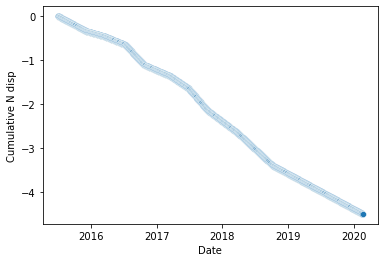

In [30]:
sns.scatterplot(data=pegs_interp.loc[pegs_interp['Name']=='Peg 11'],x='Date',y='Cumulative N disp')

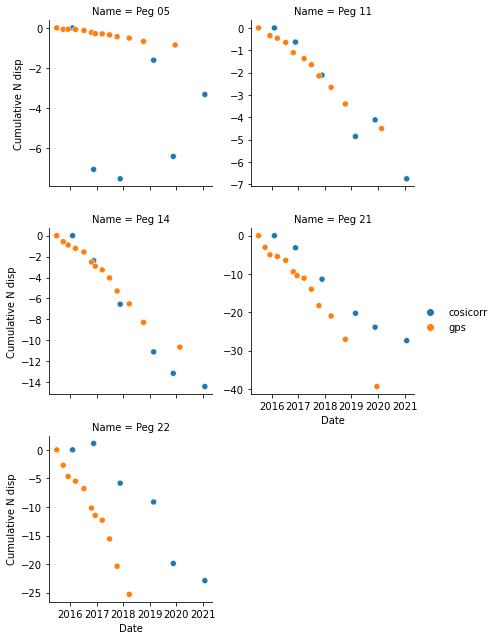

In [13]:
comparison = pd.read_csv('peg_data/comparsion.csv',parse_dates=['Date'])
names = ['P5','P11','P14','P21','P22',]
g = sns.FacetGrid(comparison, col='Name',sharey=False, col_wrap=2)
g.map(sns.scatterplot, 'Date', 'Cumulative N disp','Source')
g.add_legend()

plt.savefig('n_displacement_comparison.png')

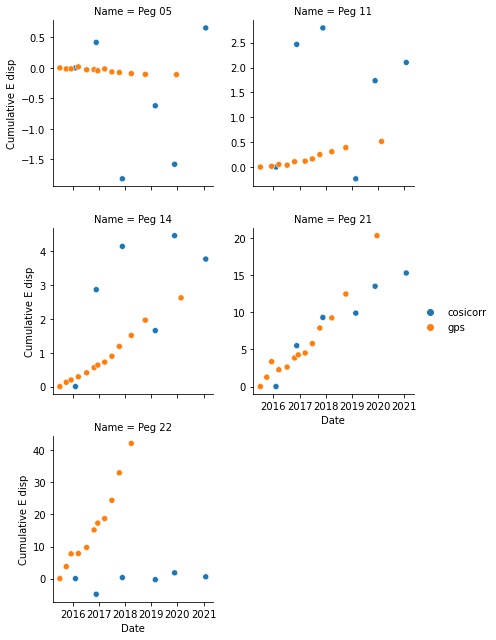

In [11]:
g = sns.FacetGrid(comparison, col='Name',sharey=False, col_wrap=2)
g.map(sns.scatterplot, 'Date', 'Cumulative E disp','Source')
g.add_legend()

In [37]:
pwd

'/home/fw/data/pixeloffset_mintpy'

## TSview

In [18]:
# visualization functions
def tsview(fname, yx=None):
    """Plot input file using tsview.py"""
    cmd = 'tsview.py {} --ms 4 --noverbose'.format(fname)
    if yx is not None:
        cmd += ' --yx {} {}'.format(yx[0], yx[1])
    print(cmd)
    obj = timeseriesViewer(cmd)
    obj.configure()
    obj.figsize_img = [5, 4]
    obj.figsize_pts = [5, 2]
    obj.plot()
    return obj

tsview.py ../upper_poroa/timeseriesAz.h5 --ms 4 --noverbose
tsview.py ../upper_poroa/timeseriesAz.h5 --ms 4 --noverbose
No lookup table info range/lat found in files.
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}


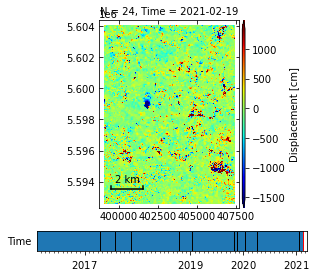

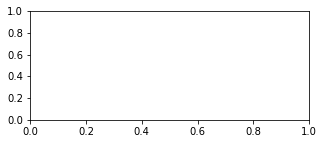

In [21]:
# timeseriesAz
obj = tsview('../upper_poroa/timeseriesAz.h5')

In [18]:
comparison

,Date,Cumulative E disp,Cumulative N disp,Name,Source
0,2016-02-06,0.000000,0.000000,Peg 05,cosicorr
1,2016-11-22,0.419062,-7.064656,Peg 05,cosicorr
2,2017-11-22,-1.820287,-7.531397,Peg 05,cosicorr
3,2019-02-25,-0.621475,-1.609496,Peg 05,cosicorr
4,2019-11-22,-1.582042,-6.414085,Peg 05,cosicorr
...,...,...,...,...,...
86,2017-06-29,-0.065394,-0.347085,Peg 05,gps
87,2017-10-11,-0.074232,-0.434565,Peg 05,gps
88,2018-03-27,-0.092793,-0.507235,Peg 05,gps
89,2018-10-09,-0.104724,-0.671735,Peg 05,gps
